**Before you dive into the implementations, I highly recommend first learning the heart of each concept —its core idea and where we use. You can explore this through YouTube tutorials, books, or online courses. This repository is meant to complement that knowledge by showing how to translate concepts into working code.**



#LSA is a technique for extracting and representing the underlying concepts (or topics) in a collection of documents. It does this by:

  **Building a Document-Term Matrix:**

  Each document is represented as a vector of word counts (or TF-IDF scores). This matrix is often very large and sparse.

  **Applying SVD:**

  SVD decomposes the matrix into three matrices:

  U: Document-topic matrix

  Σ (Sigma): Diagonal matrix of singular values (representing the strength of each topic)
  
  Vᵀ: Topic-term matrix

  By keeping only the top k singular values (a process known as truncated SVD), LSA captures the most important patterns in the data, which correspond to latent topics.

  **Interpreting the Results:**
  
  The rows of the truncated Vᵀ (or columns of V) represent topics. Each topic is described by a set of words weighted by their importance. We can then create a DataFrame to neatly display each topic and its top words.

In [ ]:
# Step 0: Install necessary packages
!pip install scikit-learn
!pip install nltk
!pip install spacy
!pip install pandas
!pip install matplotlib
!pip install wordcloud

# Download spaCy model (if not already installed)
!python -m spacy download en_core_web_sm


In [2]:
# Import libraries and load data
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load a subset of 20 Newsgroups (using 1000 documents for speed)
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = newsgroups.data[:1000]

# Define stopwords
stop_words = set(stopwords.words('english'))

In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a preprocessing function with lemmatization and optional POS filtering.
def spacy_preprocess(text, filter_pos=True):
    """
    Process text using spaCy: clean, lowercase, lemmatize.
    If filter_pos is True, only keep tokens with POS in allowed set.
    """
    doc = nlp(text)
    if filter_pos:
        allowed_pos = {'NOUN', 'VERB', 'ADJ'}
        tokens = [token.lemma_.lower() for token in doc
                  if token.pos_ in allowed_pos and token.is_alpha
                  and token.text.lower() not in stop_words and len(token.text) > 2]
    else:
        tokens = [token.lemma_.lower() for token in doc
                  if token.is_alpha and token.text.lower() not in stop_words and len(token.text) > 2]
    return " ".join(tokens)

# Preprocess all documents (set filter_pos=True to filter by POS)
cleaned_data = [spacy_preprocess(doc, filter_pos=True) for doc in data]


In [5]:
#Convert documents into a TF-IDF weighted document-term matrix.
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5)
tfidf_matrix = vectorizer.fit_transform(cleaned_data)
terms = vectorizer.get_feature_names_out()


In [6]:
# Apply Truncated SVD to perform LSA.
# Here, we set the number of topics (components) to 5.
num_topics =5
svd_model = TruncatedSVD(n_components=num_topics, random_state=1, n_iter=20)
lsa_matrix = svd_model.fit_transform(tfidf_matrix)

# The svd_model.components_ array has shape (num_topics, number_of_terms)
components = svd_model.components_


In [14]:
# Number of top words to show for a document and for a topic
num_top_words_doc = 5
num_top_words_topic = 10

# For each document, extract the top words based on the TF-IDF vector
doc_top_words = []
for i in range(tfidf_matrix.shape[0]):
    doc_vector = tfidf_matrix[i].toarray().flatten()
    # Get indices of nonzero elements and sort them by TF-IDF weight (descending)
    nonzero_indices = np.where(doc_vector > 0)[0]
    top_indices = nonzero_indices[np.argsort(doc_vector[nonzero_indices])[::-1]][:num_top_words_doc]
    top_words = [terms[j] for j in top_indices]
    doc_top_words.append(", ".join(top_words))

# For each document, get the dominant topic from the LSA representation
dominant_topics = np.argmax(lsa_matrix, axis=1)

# For each topic, extract the top words from the SVD components
topic_top_words = {}
for topic_idx, topic in enumerate(components):
    top_indices = topic.argsort()[::-1][:num_top_words_topic]
    top_words_topic = [terms[i] for i in top_indices]
    topic_top_words[topic_idx] = ", ".join(top_words_topic)

# Create a DataFrame to display a side-by-side comparison
df_compare = pd.DataFrame({
    'Truncated Original': [doc[:100].replace('\n',' ') + "..." for doc in data[:5]],
    'Document Top TF-IDF Words': doc_top_words[:5],
    'Dominant Topic': dominant_topics[:5],
    'Topic Top Words (from SVD)': [topic_top_words[dom] for dom in dominant_topics[:5]]
})

df_compare


,Truncated Original,Document Top TF-IDF Words,Dominant Topic,Topic Top Words (from SVD)
0,I am sure some bashers of Pens fans are pret...,"bit, fun, season, regular, game",4,"get, game, team, go, time, play, file, year, w..."
1,My brother is in the market for a high-perform...,"performance, card, high, vesa, brother",1,"use, file, card, window, thank, driver, progra..."
2,\tFinally you said what you dream about. M...,"weapon, plane, shoot, armenian, announce",0,"use, get, know, think, people, say, make, work..."
3,Think! It's the SCSI card doing the DMA tran...,"transfer, bus, device, datum, seek",1,"use, file, card, window, thank, driver, progra..."
4,1) I have an old Jasmine drive which I cann...,"tape, system, drive, utility, use",0,"use, get, know, think, people, say, make, work..."


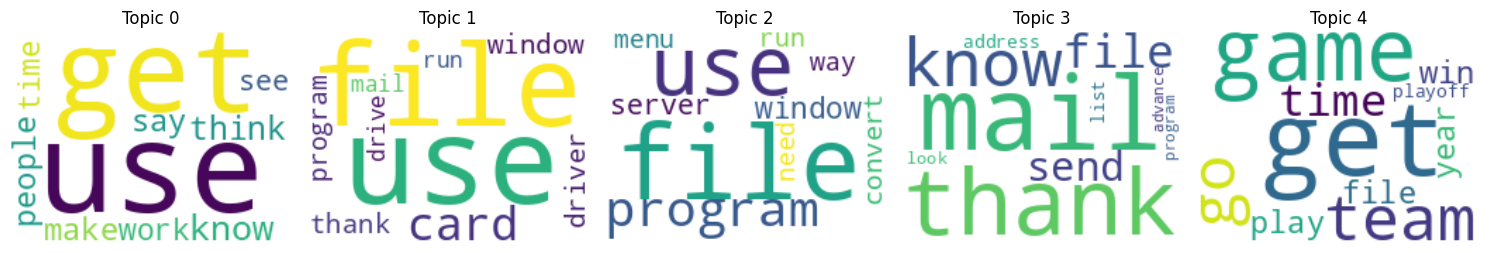

In [16]:
#Visualize topics with Word Clouds.(optional)
# Create a compact grid (2 rows x 5 columns) for the 10 topics.
fig, axes = plt.subplots(1, 5, figsize=(15, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # Get the top words and their weights for topic i
    topic_weights = components[i]
    num_top_words=10
    top_indices = topic_weights.argsort()[::-1][:num_top_words]
    topic_dict = {terms[idx]: topic_weights[idx] for idx in top_indices}

    # Generate the word cloud
    wc = WordCloud(width=200, height=150, background_color='white', colormap='viridis') \
            .generate_from_frequencies(topic_dict)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {i}", fontsize=12)

plt.tight_layout()
plt.show()


The above redundancy you're observing in the topics extracted by Latent Semantic Analysis (LSA) is a known limitation of the method. LSA relies on Singular Value Decomposition (SVD) to reduce the dimensionality of the term-document matrix, capturing latent semantic structures. However, this approach can lead to overlapping or redundant topics, as LSA doesn't inherently enforce distinctiveness among the topics.

Alternative Topic Modeling Techniques: Probabilistic models like Latent Dirichlet Allocation (LDA) are designed to produce more distinct topics by assuming a generative process for the documents. LDA often results in topics that are more interpretable and less redundant compared to those from LSA.

Both LSA and LDA serves different purposes. In summary, while both LSA and LDA are valuable tools in topic modeling, LDA often provides more distinct and interpretable topics, making it preferable for applications where topic clarity is essential. However, LSA's strengths in capturing semantic relationships can be advantageous in tasks like information retrieval and synonym detection.